<a href="https://colab.research.google.com/github/mgfrantz/CTME-llm-lecture-resources/blob/main/prototyping_ai/01_getting_started_with_llms_20241123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making our first LLM API call



## Setup

In [1]:
try:
    from google.colab import userdata
    print("Colab notebook detected. Installing dependencies...")
    !pip install -Uqqqq \
        openai \
        chromadb \
        sentence-transformers \
        llama-index \
        llama-index-llms-openai \
        gradio \
        datasets \
        dspy-ai

except:
    print("Not in Colab. Skipping installation.")


Colab notebook detected. Installing dependencies...


In [2]:
# Basic imports
from rich import print
import gradio as gr
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, mean_absolute_error

# OpenAI
from openai import OpenAI

## Setting our `OPENAI_API_KEY` environment variable

When we use any LLM provider like OpenAI, Anthropic, or Google, we need some way to tell them who we are making the request.
Today, we'll be using OpenAI.
The most straightforward way to provide this key is through the environment variable `OPENAI_API_KEY`.
The OpenAI python client looks for this environment variable to use in authentication.

In the cell below, we load it from the Google Colab secrets manager on the left 👈.
Before runnign this code, make sure your API key is set as shown below:

![](https://github.com/mgfrantz/CTME-llm-lecture-resources/blob/main/images/colabSecrets.png?raw=true)

In [3]:
# Set the OPENAI_API_KEY environment variable
try:
    from google.colab import userdata # import the environment variables from secrets
    os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY') # Set the OPENAI_API_KEY environmnet variable
except:
    import dotenv
    env_loaded = dotenv.load_dotenv('../.env')
    if not env_loaded:
        raise ValueError("Failed to load environment variables from .env file.")
    else:
        print("Loaded environment variables from .env file.")


## Under the hood: `curl`

Almost all of the interactions we will have with LLMs are through API calls.
Below is one of the most low-level ways we can call an LLM, using the `curl` command.
This command gives us a lot of information about how the API request is structured.
We pass a JSON with an authorization header containing our `OPENAI_API_KEY`.
We also pass the model we want to call, the chat messages, and hyperparameters such as `temperature` that help control how text is generated.

In [4]:
# Make the API call to OpenAI and store the response in test.json
!curl https://api.openai.com/v1/chat/completions \
  -H "Content-Type: application/json" \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -d '{ \
     "model": "gpt-4o-mini", \
     "messages": [{"role": "user", "content": "Say: This is a test!"}], \
     "temperature": 0.7 \
    }' > test.json
# Show the output of test.json formatted nicely
!cat test.json | python -m json.tool

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   765  100   136   1283    228 --:--:-- --:--:-- --:--:--  1514
{
    "id": "chatcmpl-AWtENdhUiX9UPGiHJsIZ3gqV89vu7",
    "object": "chat.completion",
    "created": 1732402167,
    "model": "gpt-4o-mini-2024-07-18",
    "choices": [
        {
            "index": 0,
            "message": {
                "role": "assistant",
                "content": "This is a test!",
                "refusal": null
            },
            "logprobs": null,
            "finish_reason": "stop"
        }
    ],
    "usage": {
        "prompt_tokens": 14,
        "completion_tokens": 5,
        "total_tokens": 19,
        "prompt_tokens_details": {
            "cached_tokens": 0,
            "audio_tokens": 0
        },
        "completion_tokens_details": {
            "reasoning_tokens": 0,
            "audio_tokens": 0,
    

## Using the OpenAI Python client

While the `curl` command shows us how the API call is made, it's not something that we can easily use in more complex applications.
One thing we can use is the OpenAI python client.
We can do the exact same thing, but the API call is a bit more abstracted from the developer.
Let's see how to perform the exact same API call using the OpenAI clinet 👇:

In [5]:
client = OpenAI() # Create the OpenAI client

In [6]:
# Create the messages (same as above)
messages = [
    {"role": "user", "content": "Say: This is a test!"},
]

# Make the API call
chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    # stream=True
)

In [7]:
# Display the output
print(chat_completion)

ChatCompletion(
    id='chatcmpl-AWtEOs1VlPVgHYRyk7YwHCzXRoBIZ',
    choices=[
        Choice(
            finish_reason='stop',
            index=0,
            logprobs=None,
            message=ChatCompletionMessage(
                content='This is a test!',
                refusal=None,
                role='assistant',
                audio=None,
                function_call=None,
                tool_calls=None
            )
        )
    ],
    created=1732402168,
    model='gpt-4o-mini-2024-07-18',
    object='chat.completion',
    service_tier=None,
    system_fingerprint='fp_0705bf87c0',
    usage=CompletionUsage(
        completion_tokens=5,
        prompt_tokens=14,
        total_tokens=19,
        completion_tokens_details=CompletionTokensDetails(
            accepted_prediction_tokens=0,
            audio_tokens=0,
            reasoning_tokens=0,
            rejected_prediction_tokens=0
        ),
        prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
    )
)

# Build our first chatbots

In this section, we'll go through several demos.
By the end of this section, you should be able to:
- Build a basic chatbot with the popular `gradio` Python library
- Understand key hyperparameters like `temperature`, `top_p`, and `top_k`
- Build an advanced chatbot with hyperparameter controls

## Exercise: Building a basic chatbot with `gradio`

User interfaces (UIs) are a great way to demo work in AI.
In the next several lessons, we will be using the `gradio` framework to demonstrate our growing skillset.
In this exercise, we will get a gentle introduction to creating chatbots with `gradio`.

Please follow the [ChatInterface](https://www.gradio.app/docs/gradio/chatinterface) documentation and the [Creating a chatbot fast](https://www.gradio.app/guides/creating-a-chatbot-fast) guide to make your first AI chatbot.
Your chatbot must:
- respond to messages

If this too easy, try to:
- add a system prompt
- use `stream=True` in your chat function

In [8]:
from time import sleep
import numpy as np

In [9]:
def chat(message:str, history:list):
    if len(history) == 0:
        history.append({
            "role": "system",
            "content": "You are a helpful assistant that speaks like a cowboy."
        })
    history.append({
        "role": "user",
        "content": message
    })
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=history,
        stream = True
    )
    resp = ""
    for chunk in response:
        sleep(np.random.random())
        resp += chunk.choices[0].delta.content or ""
        yield resp

In [10]:
gen = chat('hello!', [])

In [11]:
list(gen)

['',
 'Howdy',
 'Howdy,',
 'Howdy, partner',
 'Howdy, partner!',
 'Howdy, partner! What',
 'Howdy, partner! What brings',
 'Howdy, partner! What brings ya',
 "Howdy, partner! What brings ya '",
 "Howdy, partner! What brings ya 'round",
 "Howdy, partner! What brings ya 'round these",
 "Howdy, partner! What brings ya 'round these parts",
 "Howdy, partner! What brings ya 'round these parts?",
 "Howdy, partner! What brings ya 'round these parts?"]

In [12]:
demo = gr.ChatInterface(fn=chat, type="messages")
demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ca0356cbaa827b2e3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Text generation hyperparameters

There are several hyperparameters we can play with that determine how text is generated.
For each token, the model outputs a score distribution over words, and that distribution is normalized using the softmax function to sum to 1.0.
We have several options to modify this probability distribution in ways that affect the way text is generated.

### `temperature`

The softmax function is shown below:

$$
\text{softmax}(p) = \frac{e^{x_i}}{\sum_{j=0}^ne^{x_j}}
$$

The softmax function is defined in python below:


In [13]:
def softmax(p):
    return np.exp(p) / np.sum(np.exp(p))

# Example usage
p = np.array([1, 2, 3, 4, 5])
print(softmax(p))
assert np.allclose(softmax(p).sum(), 1.0)

[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]

The `temperature` paramater allows us to make the most probable words more probable (temperature < 1) or less probable (temperature > 1) than vanilla softmax (temperature = 1).
The formula for softmax with temperature is show below:

$$
\text{softmax}(p, T) = \frac{e^{\frac{x_i}{T}}}{\sum_{j=0}^ne^{\frac{x_j}{T}}}
$$

All you do is divide everything by T before taking the exponent; larger values of $T$ flatten the distribution, while smaller values of $T$ skew the distribution towards the most probable tokens.

### Exercise: Softmax with temperature

In [14]:
# Softmax function with temperature parameter
def softmax_with_temperature(probs, temperature):
    return np.exp(probs/temperature) / np.sum(np.exp(probs/temperature))

In [15]:
# Define a small probability distribution
probs = np.array([0.5, 0.3, 0.1, 0.05, 0.05])

# Plot the distribution with numbers on top of each bar
def plot_distribution(temperature):
    adjusted_probs = softmax_with_temperature(probs, temperature)
    plt.figure(figsize=(6, 4))
    bars = plt.bar(range(len(probs)), adjusted_probs, tick_label=['A', 'B', 'C', 'D', 'E'])
    plt.ylim(0, 1)
    plt.title(f'Softmax with Temperature = {temperature:.2f}')
    plt.ylabel('Probability')
    plt.xlabel('Tokens')

    # Add numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Interactive widget
interact(plot_distribution, temperature=(0.1, 2.0, 0.1));

interactive(children=(FloatSlider(value=1.0, description='temperature', max=2.0, min=0.1), Output()), _dom_cla…

### Demo: Alter the `temperature` parameter

In this demo, we generate several messages from the same prompt.
If we lower the temperature to 0, what do you notice about the results?
What if we raise it above 1.0?

In [16]:
messages = [
    {"role": "user", "content": "01. Write a python function that reverses a string. Tell a joke in the docstring!"},
]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.8, # change this number between 0 and 2 to see the outcome
    n=3 # generate 3 choices
)

In [17]:
for choice in response.choices:
    print(choice.message.content)
    print('\n\n' + '='*50 + '\n')

Here's a Python function that reverses a string, along with a joke in the docstring:

```python
def reverse_string(s: str) -> str:
    """
    Reverses a given string.

    Why did the scarecrow win an award?
    Because he was outstanding in his field!
    
    Parameters:
    s (str): The string to be reversed.

    Returns:
    str: The reversed string.
    """
    return s[::-1]

# Example usage
print(reverse_string("Hello, World!"))  # Output: !dlroW ,olleH
```

You can use the `reverse_string` function to reverse any string you pass to it. Enjoy the joke, too!

==================================================

Here's a Python function that reverses a string, along with a joke in the docstring!

```python
def reverse_string(s):
    """
    Reverses the input string.

    Why did the scarecrow win an award?
    Because he was outstanding in his field!
    """
    return s[::-1]
```

You can use this function by passing a string to it like so:

```python
print(reverse_string("Hello, World!"))  # Outputs: !dlroW ,olleH
```

==================================================

Here's a Python function that reverses a string, along with a joke in the docstring:

```python
def reverse_string(input_string):
    """
    Reverse the given string and return the result.

    Joke: Why do programmers prefer dark mode?
    Because light attracts bugs!
    """
    return input_string[::-1]

# Example usage:
reversed_string = reverse_string("Hello World")
print(reversed_string)  # Output: "dlroW olleH"
```

In this function, `input_string[::-1]` slices the string from end to start, effectively reversing it. Feel free to 
call the function `reverse_string` with your own string inputs!

==================================================

### Demo: `top_k`

In top k sampling, we define the number of tokens we want to consider to sample from.
For example if `top_k = 3`, we will take the scores of the top 3 tokens and apply the softmax to only those 3 scores.
Run the code block below to see how `top_k` normalizes the scores at different values.

In [18]:
# Define a small probability distribution
probs = np.array([0.5, 0.3, 0.1, 0.05, 0.05])

# Plot the distribution with numbers on top of each bar
def plot_top_k(top_k):
    ticks = ['A', 'B', 'C', 'D', 'E']
    sorted_probs = np.sort(probs)[::-1]
    top_k_probs = sorted_probs[:top_k]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    adjusted_probs = softmax(probs)
    ax = axes[0]
    bars = ax.bar(range(len(probs)), adjusted_probs, tick_label=ticks)
    ax.set_ylim(0, 1)
    ax.set_title('Original Probabilities')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Token')

    # Add numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    ax = axes[1]
    if top_k < len(probs):
        updated_probs = softmax(probs[:top_k])
        bars = ax.bar(range(top_k), updated_probs, tick_label=ticks[:top_k])
    else:
        bars = ax.bar(range(len(probs)), softmax(probs), tick_label=ticks)
    ax.set_ylim(0, 1)
    ax.set_title(f'Top {top_k} Probabilities')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Token')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Interactive widget
interact(plot_top_k, top_k=(1, len(probs), 1));

interactive(children=(IntSlider(value=3, description='top_k', max=5, min=1), Output()), _dom_classes=('widget-…

### Demo: `top_p` (aka nucleus sampling)

`top_p` is similar to `top_k`, but instead of defining the number of tokens to consider, you define a cutoff for cumulative probability.
For example, if you have a top_p of 0.6 and score of ('cat', 0.4), ('dog', 0.15), ('llama', 0.1), and ('parakeet', 0.01), you would cut only consider 'cat', 'dog', and 'llama' because 0.4 + 0.15 is less than 0.6, but 0.4 + 0.15 + 0.1 is greater.
Because you have a probability cutoff instead of number of tokens, this may mean you have different numbers of tokens considered at each decoding step.

Play around with the `top_p` slider below 👇 to get some intuition for how it works.

In [19]:
# Define a small probability distribution (can simulate a language model's logits)
probs = np.array([0.4, 0.2, 0.15, 0.1, 0.08, 0.05, 0.02])

# Function to apply top-p filtering with a minimum of one token selected
def top_p_filter(probs, p):
    sorted_probs = np.sort(probs)[::-1]
    cumulative_probs = np.cumsum(sorted_probs)

    # Ensure at least one token is selected
    if p < sorted_probs[0]:
        cutoff = 1
    else:
        cutoff = np.argmax(cumulative_probs >= p) + 1

    filtered_probs = sorted_probs[:cutoff]
    return filtered_probs, cutoff

# Plot the distribution with top-p filtering
def plot_top_p(p):
    filtered_probs, cutoff = top_p_filter(probs, p)
    normalized_probs = filtered_probs / np.sum(filtered_probs)  # Normalize the selected probabilities

    # Create two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

    # Plot 1: Original distribution with top-p filtering
    bars1 = axs[0].bar(range(len(probs)), np.sort(probs)[::-1], tick_label=labels)
    axs[0].set_ylim(0, 1)
    axs[0].set_title(f'Top-p Sampling (p = {p:.2f}) - Original Probabilities')
    axs[0].set_ylabel('Probability')
    axs[0].set_xlabel('Tokens')

    # Highlight selected and unselected probabilities
    for i, bar in enumerate(bars1):
        if i >= cutoff:
            bar.set_color('gray')  # Color the bars outside top-p as gray
        else:
            bar.set_color('blue')  # Highlight the selected probabilities

    # Add numbers on top of each bar for original distribution
    for bar in bars1:
        yval = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    # Plot 2: Normalized probabilities of the selected tokens
    bars2 = axs[1].bar(range(len(filtered_probs)), normalized_probs, tick_label=labels[:len(filtered_probs)])
    axs[1].set_ylim(0, 1)
    axs[1].set_title(f'Normalized Probabilities of Selected Tokens (p = {p:.2f})')
    axs[1].set_ylabel('Normalized Probability')
    axs[1].set_xlabel('Selected Tokens')

    # Add numbers on top of each bar for normalized probabilities
    for bar in bars2:
        yval = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(plot_top_p, p=(0.01, 1.0, 0.05));

interactive(children=(FloatSlider(value=0.46, description='p', max=1.0, min=0.01, step=0.05), Output()), _dom_…

## Exercise: Advanced chatbot with hyperparameter controls

Now that you've learned about roles and generation hyperparameters, let's create a new chatbot that allows you to contol at them.
Your chatbot must:
- allow for control of at least 1 generation hyperparameter (ex: `temperature`)
- allow for user input of a system message

If this is too easy, try to:
- allow for control over `temperature` and `top_p`
- improve the UI by putting all the controls in a sidebar
- have a `Clear` button that restarts the conversation
- add documentation with markdown
- implement streaming responses

In [20]:
def chat(message, history, system_message, temperature, top_p):
    if len(history) == 0 and system_message:
        history.append({
            "role": "system",
            "content": system_message
        })
    history.append({
        "role": "user",
        "content": message
    })
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=history,
        temperature=temperature,
        top_p=top_p,
    )
    history.append({
        "role": "assistant",
        "content": response.choices[0].message.content
    })
    return history, None

def clear():
    return [], None

In [21]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=1):
            temperature = gr.Slider(minimum=0, maximum=2, value=1, step=0.1, label='Temperature', interactive=True)
            top_p = gr.Slider(minimum=0, maximum=1, value=1, step=0.1, label='Top p', interactive=True)
            system_prompt = gr.Textbox(label='System prompt', interactive=True, value="You are a helpful assistant.")
            clear_button = gr.Button(value='Clear')
        with gr.Column(scale=5):
            chatbot = gr.Chatbot(type="messages")
            input_box = gr.Textbox(label='Message')

    input_box.submit(chat, [input_box, chatbot, system_prompt, temperature, top_p], [chatbot, input_box])
    clear_button.click(clear, outputs=[chatbot, input_box])

demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://39ab23b1eae1585e13.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Prompt engineering 1: zero-shot prompting

To really benchmark how each of these techniques do, we need a baseline.
We will use zero-shot prompting to get a base level of performance on our task.

So far, we've been using the low-level `openai` library.
However, there are several very competent higher-level libraries that provide great abstractions such as `langchain` and `llama-index`.
Today, we'll be using `llama-index` to make our LLM calls a bit easier.

## Prepare our dataset

In [22]:
# Prompt engineering imports
from datasets import load_dataset, Dataset
from llama_index.core import PromptTemplate
from llama_index.core.prompts import ChatMessage
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
from IPython.display import display
import asyncio

In [23]:
ds = load_dataset('SetFit/amazon_reviews_multi_en')

In [24]:
train_samples_per_class = 50
eval_test_samples_per_class = 10
train = Dataset.from_pandas(ds['train'].to_pandas().groupby('label').sample(train_samples_per_class, random_state=1234).reset_index(drop=True))
valid = Dataset.from_pandas(ds['validation'].to_pandas().groupby('label').sample(eval_test_samples_per_class, random_state=1234).reset_index(drop=True))
test = Dataset.from_pandas(ds['test'].to_pandas().groupby('label').sample(eval_test_samples_per_class, random_state=1234).reset_index(drop=True))

In [25]:
train.to_pandas().sample(3)

,id,text,label,label_text
194,en_0597972,A bit large for a size 8. But it shines so nic...,3,3
141,en_0009688,These sheets are kind of weird. They don't sta...,2,2
9,en_0945958,I sent retuned this because it didn’t work and...,0,0


In [26]:
async def predict_and_evaluate(predict_fn):
    labels = [int(x) for x in valid['label']]
    tasks = [
        predict_fn(text)
        for text in valid['text']
    ]
    predictions = await asyncio.gather(*tasks)
    cm = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')
    cr = classification_report(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions, weights='quadratic')
    mae = mean_absolute_error(labels, predictions)
    return labels, predictions, kappa, mae, cm, cr

## Zero-shot prompt

In [27]:
prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the score of the review.

Query: What is the rating of this review?
Answer: \
"""

prompt_tmpl = PromptTemplate(
    prompt_tmpl_str,
)

In [28]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
zero_shot_structured_llm = llm.as_structured_llm(Rating)

In [29]:
async def zero_shot_predict(text):
    messages = [
        ChatMessage.from_str(prompt_tmpl.format(review=text))
    ]
    response = await zero_shot_structured_llm.achat(messages)
    return response.raw.rating

In [30]:
messages = [
    ChatMessage.from_str(prompt_tmpl.format(review="I loved this product!"))
]

Aside: compare times between sync and async calls to OpenAI

In [31]:
%%time
for i in range(5):
    print(f"Sending request {i}")
    response = zero_shot_structured_llm.chat(messages)

Sending request 0

Sending request 1

Sending request 2

Sending request 3

Sending request 4

CPU times: user 151 ms, sys: 15.5 ms, total: 166 ms
Wall time: 3.48 s


In [32]:
%%time
async def _predict(i):
    print(f"Sending request {i}")
    response = await zero_shot_structured_llm.achat(messages)
    return response
tasks = [_predict(i) for i in range(5)]

responses = asyncio.run(asyncio.gather(*tasks))

RuntimeError: asyncio.run() cannot be called from a running event loop

In [33]:
responses[0]

NameError: name 'responses' is not defined

Cohen's Kappa: 0.8571, MAE: 0.48

precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.38      0.60      0.46        10
           2       0.45      0.50      0.48        10
           3       0.75      0.30      0.43        10
           4       0.71      1.00      0.83        10

    accuracy                           0.56        50
   macro avg       0.62      0.56      0.55        50
weighted avg       0.62      0.56      0.55        50

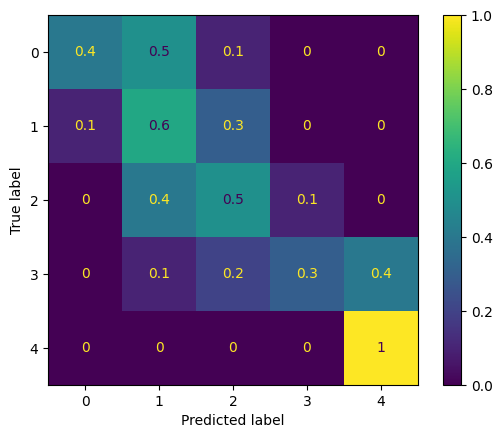

In [34]:
zero_shot_labels, zero_shot_predictions, zero_shot_kappa, zero_shot_mae, zero_shot_cm, zero_shot_cr = await predict_and_evaluate(zero_shot_predict)
print(f"Cohen's Kappa: {zero_shot_kappa:.04f}, MAE: {zero_shot_mae}")
print(zero_shot_cr)

# Prompt engineering 2: few-shot promting

In the following cell, we load and parse the data.
The data here is uber reviews

In [35]:
train.shuffle()[:5]

{'id': ['en_0894197', 'en_0512487', 'en_0821675', 'en_0011275', 'en_0338895'],
 'text': ['Great starter, works like it supposed to! Love it!',
  'Little metal nub that locks handle into jack broke off on first use......And felt handle was a bit short.',
  'Bought them for myself and gave them as a gift. Super strong and sturdy.',
  'Two chargers, 2 ports each, 2 cables, good price, works perfectly, came the next day!',
  'The crowns worked perfectly for our 7th grade pageant winners. They sparkle, shine, and fit the budget.'],
 'label': [4, 0, 4, 4, 4],
 'label_text': ['4', '0', '4', '4', '4']}

In [36]:
rng = np.random.Generator(np.random.PCG64(1234))

def random_few_shot_examples_fn(**kwargs):
    if n_samples:=kwargs.get('n_samples'):
        random_examples = train.shuffle(generator=rng)[:n_samples]
    else:
        random_examples = train.shuffle(generator=rng)[:5]

    result_strs = []
    for text, rating in zip(random_examples['text'], random_examples['label']):
        result_strs.append(f"Text: {text}\nRating: {rating}")
    return "\n\n".join(result_strs)

In [37]:
print(random_few_shot_examples_fn())

Text: My daughter loves it.
Rating: 4

Text: I only use one time for my dog, it really work well, I can see the reduce the ear affection, but it has the 
small my dog doesn't like. If it can be no sense that would be better.
Rating: 3

Text: Bought it for my Boyfriend while I am away for a few months. When it even works the camera is glitchy.
Rating: 0

Text: Great screen tent, however I tried to set it up by myself and I accidentally set it up inside out. Watch the 
YouTube video before setting it up.
Rating: 4

Text: It was not the Kevlar belt that should have been sent. Just cheap rubber. Won’t last long...kept it in 
packaging until I needed it...return window closed...sucks!
Rating: 0

In [38]:
few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{random_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

few_shot_prompt_tmpl = PromptTemplate(
    few_shot_prompt_tmpl_str,
    function_mappings={"random_few_shot_examples": random_few_shot_examples_fn},
)

In [39]:
print(few_shot_prompt_tmpl.format(review='I loved this product!', n_samples=2))

The review text is below.
---------------------
I loved this product!
---------------------
Given the review text and not prior knowledge, please attempt to predict the review score of the context. Here are 
several examples of reviews and their ratings:

Text: Is nice but it's outside and many rusty
Rating: 0

Text: Good quality, exact fit and arrives quickly
Rating: 4

Query: What is the rating of this review?
Answer:

In [40]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
rand_few_shot_structured_llm = llm.as_structured_llm(Rating)

In [41]:
import pandas as pd

In [42]:
async def random_few_shot_predict(text, n_examples=5):
    tasks = []
    for _ in range(3):
        messages = [
            ChatMessage.from_str(few_shot_prompt_tmpl.format(review=text, n_samples=n_examples))
        ]
        tasks.append(rand_few_shot_structured_llm.achat(messages, temperature=0.9))
    results = await asyncio.gather(*tasks)
    ratings = [r.raw.rating for r in results]
    # print(ratings)
    return pd.Series(ratings).mode()[0]

Cohen's Kappa: 0.8541, MAE: 0.5

precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.38      0.60      0.46        10
           2       0.46      0.60      0.52        10
           3       0.60      0.30      0.40        10
           4       0.69      0.90      0.78        10

    accuracy                           0.52        50
   macro avg       0.56      0.52      0.49        50
weighted avg       0.56      0.52      0.49        50

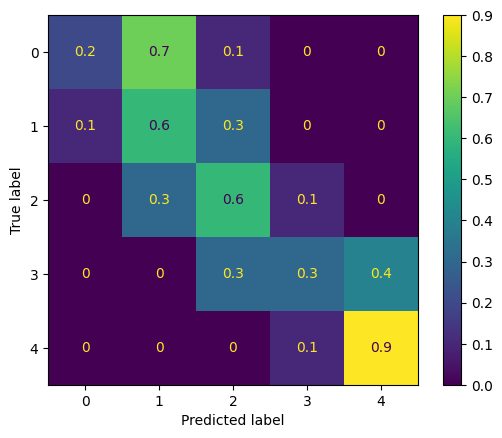

In [43]:
random_few_shot_labels, random_few_shot_predictions, random_few_shot_kappa, random_few_shot_mae, random_few_shot_cm, random_few_shot_cr = await predict_and_evaluate(random_few_shot_predict)
print(f"Cohen's Kappa: {random_few_shot_kappa:.04f}, MAE: {random_few_shot_mae}")
print(random_few_shot_cr)

# Demo: Embeddings and vector stores

In the previous demonstration, we saw that providing several randomly-selected examples to the LLM at inference time does decently well - it's decently good at predicting the review score, especially within 1 point of the actual review.
In a little bit, we'll see that providing better examples to the model at inference time helps improve these scores.
But we need efficient ways of searching over our `train` examples to determine which one to use.

This is when you want to use a vector store.
Vector stores can be in-memory stors, on-disk stores, database extensions like pgvector for Postgres, or even external APIs like Pinecone.

Today, we'll use a popular open-source vectore database called `chromadb`.
This tool allows us to ingest our documents and search over them effectively to determine which examples to use.

In this demo, we'll go over the basics of how to use ChromaDB.
We will also use `sentence-transformers` for embeddings as an example of how to use open-weights embedding models.

In [44]:
# Imports
from chromadb import Client
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In this cell, we declare our embedding function.
We will use the small but powerful [BGE-small](https://huggingface.co/BAAI/bge-small-en-v1.5) model to embed our documents.

In [45]:
embed_fn = SentenceTransformerEmbeddingFunction('BAAI/bge-small-en-v1.5')

Next, we can create our `chromadb` client and use it to create our collection (think table).
Notice that we pass our embedding function.
That way, when we add documents to the table, the the text is automatically embedded.

In [46]:
chroma_client = Client()

In [47]:
reviews = chroma_client.create_collection(
    name='reviews',
    embedding_function=embed_fn,
    get_or_create=True
)

In [48]:
reviews.add(documents=train['text'], metadatas=[{'rating': x} for x in train['label']], ids=train['id'])

Once we have created our vector store, we can search over it using plain text.
Here are 3 queries - good review, a neutral review, and a bad review.
Let's search our train documents and observe the average rating for the closest 5 documents to each fake review.

In [49]:
queries = [
    "This product is great!",
    "This product was pretty typical - not good or bad.",
    "This product was awful",
]

In [50]:
retrievals = reviews.query(
    query_texts=queries,
    n_results=5
)

In [51]:
for query, metadatas in zip(queries, retrievals['metadatas']):
    ratings = [float(i.get('rating')) for i in metadatas]
    print(f"Review {query}")
    print(f"Avg rating of retrieved passages: {np.mean(ratings)}")

Review This product is great!

Avg rating of retrieved passages: 3.8

Review This product was pretty typical - not good or bad.

Avg rating of retrieved passages: 1.4

Review This product was awful

Avg rating of retrieved passages: 0.6

In [52]:
reviews.query(query_texts = 'hello!')['documents']

[['Great purchase! It’s my I watch perfect and easy to attach!',
  'Great starter, works like it supposed to! Love it!',
  'Just received, easy to set up and use.',
  'Love how structured it is for a small pillow! It’s nice to have the support and not take up the whole bed!',
  'Good product works great!',
  'A bit large for a size 8. But it shines so nice!! Looks great. It’s a tad brighter and lighter than my real diamonds but perhaps with wear it’ll settle in. Looks great with my real diamonds! Love it.',
  'My speaker is really loud and I’m happy about it... The instructions were simple and easy to follow but ... I didn’t receive any cords to charge the speaker or connect it to anything ... and still waiting for a response from the supplier or Amazon',
  "Got to me on time and packaged well. Haven't seen the end result (what it is being used for as it was a gift) but not complaints so far!",
  'Made a wonderful "GAG" gift. Bought it for a gag gift for my best friend, it was hilariou

## Discussion: Using vector stores

Now that we have our data encoded this way, can anyone tell me how we might use this object to improve the way we classify reviews?

# Prompt engineering 3: dynamic few-shot prompting

In [53]:
def dynamic_few_shot_examples_fn(**kwargs):
    n_examples = kwargs.get('n_examples', 5)
    retrievals = reviews.query(
        query_texts=[kwargs['review']],
        n_results=n_examples
    )
    result_strs = []
    documents = retrievals['documents'][0]
    metadatas = retrievals['metadatas'][0]
    for document, metadata in zip(documents, metadatas):
        result_strs.append(f"Text: {document}\nRating: {metadata.get('rating')}")
    return "\n\n".join(result_strs)

In [54]:
print(dynamic_few_shot_examples_fn(review="This is the best product I've ever bought!"))

Text: Good product works great!
Rating: 3

Text: Great purchase! It’s my I watch perfect and easy to attach!
Rating: 4

Text: We have a small area and limited outlet availability. With the amount of electronics we have is hard to make 
room for all of it! This is super helpful to save on space! Fast charging and compatible with Apple (some products 
give you an error code; "not compatible" or whatever). Has been a life saver! Will probably order another one for 
our cars!
Rating: 4

Text: This product came to us quickly and in perfect condition. It was packaged well and exactly as described.
Rating: 4

Text: These combs are beautiful and are great quality. They not only help reduce static during the winter, but the 
feel so sleek against my scalp and hair. I love them.
Rating: 4

In [55]:
print(dynamic_few_shot_examples_fn(review="This is the worst product I've ever bought!", n_examples=2))

Text: I would give this zero stars if I could. This product is a piece of crap! I used both protectors and on first
try, neither protectors stuck to the phone. It’s not like I tried multiple times for it to line up.. no it wouldn’t
stick on first try n i know how to put on screen protectors. Terrible product!
Rating: 0

Text: This is a waste of money! The amount of slime this kit makes is so tiny. You will be much further ahead by 
buying glue, glitter, and any other slime ingredients separately. The packaging makes it look appealing but it is 
very disappointing.
Rating: 0

In [56]:
dynamic_few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{dynamic_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

dynamic_few_shot_prompt_tmpl = PromptTemplate(
    dynamic_few_shot_prompt_tmpl_str,
    function_mappings={"dynamic_few_shot_examples": dynamic_few_shot_examples_fn},
)

In [123]:
print(dynamic_few_shot_prompt_tmpl.format(review='I hated this product!', n_examples=1))

The review text is below.
---------------------
I hated this product!
---------------------
Given the review text and not prior knowledge, please attempt to predict the review score of the context. Here are 
several examples of reviews and their ratings:

Text: I would give this zero stars if I could. This product is a piece of crap! I used both protectors and on first
try, neither protectors stuck to the phone. It’s not like I tried multiple times for it to line up.. no it wouldn’t
stick on first try n i know how to put on screen protectors. Terrible product!
Rating: 0

Query: What is the rating of this review?
Answer:

In [58]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
dynamic_few_shot_structured_llm = llm.as_structured_llm(Rating)

async def dynamic_few_shot_predict(text, n_examples=5):
    messages = [
        ChatMessage.from_str(dynamic_few_shot_prompt_tmpl.format(review=text, n_examples=n_examples))
    ]
    response = await dynamic_few_shot_structured_llm.achat(messages)
    return response.raw.rating

Cohen's Kappa: 0.8557, MAE: 0.44

precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.44      0.40      0.42        10
           2       0.44      0.70      0.54        10
           3       0.80      0.40      0.53        10
           4       0.77      1.00      0.87        10

    accuracy                           0.62        50
   macro avg       0.66      0.62      0.61        50
weighted avg       0.66      0.62      0.61        50

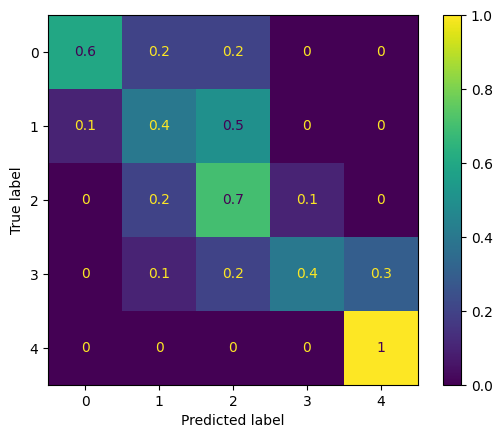

In [59]:
dynamic_few_shot_labels, dynamic_few_shot_predictions, dynamic_few_shot_kappa, dynamic_few_shot_mae, dynamic_few_shot_cm, dynamic_few_shot_cr = await predict_and_evaluate(dynamic_few_shot_predict)
print(f"Cohen's Kappa: {dynamic_few_shot_kappa:.04f}, MAE: {dynamic_few_shot_mae}")
print(dynamic_few_shot_cr)

# Exercise: Rating Reviews

In today's session, we've learned about:
- Chat models, interfaces, and `gradio`
- Zero shot prompting
- Few shot learning
- Embeddings and vector stores
- Dynamic few shot learning

It's time to combine these principles into our final exercise of the day.
Your task is to create a `gradio` app where a user can paste a review from Amazon and the app displays the predicted number of ⭐stars⭐.
To complete this task, please:
- Create a GradIO app with...
  - an input field where a user can submit text
  - a submit button and/or functionality to submit the text to the app when the user hits the return key
  - an output field to display the predicted result

If this is too easy, try to:
- Add hyperparameters like the number of examples retrieved
- Add details in markdown for how to use the app
- Display the prompt and response for inspection
- Install the [`gradio-client`](https://pypi.org/project/gradio-client/) library and make requests to your app from this notebook

If you're done, and **really** want to challenge yourslef, add a dropdown for a different model.
You can follow the `Gemini API keys` button in the 👈secrets🔑 tab of Colab, or follow [this notebook guide](https://github.com/mgfrantz/CTME-llm-lecture-resources/blob/main/resources/ollama.ipynb) on a GPU colab to try doing inference with local LLMs like llama3 (Recommended to restart and use a gpu runtime, runtime > change runtime type. May not work with `.as_structured_llm`, check out [this low-level guide on structured outputs](https://docs.llamaindex.ai/en/stable/examples/output_parsing/llm_program/)).


In [60]:
def classify(review, num_examples, api_key):
    llm = OpenAI(model="gpt-4o-mini", api_key=api_key).as_structured_llm(Rating)
    zero_shot = asyncio.run(zero_shot_predict(review))
    random_few_shot = asyncio.run(random_few_shot_predict(review, num_examples))
    dynamic_few_shot = asyncio.run(dynamic_few_shot_predict(review, num_examples))
    return zero_shot, random_few_shot, dynamic_few_shot

In [65]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            api_key = gr.Textbox(label='Openai API Key')
            n_examples = gr.Slider(minimum=1, maximum=10, value=5, step=1, label='Number of examples to retrieve', interactive=True)
            review = gr.Textbox(label='Review', interactive=True)
            submit = gr.Button(value='Submit')
        with gr.Column():
            zero_shot_label = gr.Textbox(label='Zero shot', interactive=False)
            random_few_shot_label = gr.Textbox(label='Random few shot', interactive=False)
            dynamic_few_shot_label = gr.Textbox(label='Dynamic few shot', interactive=False)

    submit.click(classify, [review, n_examples], [zero_shot_label, random_few_shot_label, dynamic_few_shot_label])

demo.queue().launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b42abdb70e597e5f7e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [69]:
!git clone https://huggingface.co/spaces/mgfrantz/CTMEPrototypingAI

Cloning into 'CTMEPrototypingAI'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.28 KiB | 1.28 MiB/s, done.


In [73]:
!pip show sentence-transformers

Name: sentence-transformers
Version: 3.3.1
Summary: State-of-the-Art Text Embeddings
Home-page: https://www.SBERT.net
Author: 
Author-email: Nils Reimers <info@nils-reimers.de>, Tom Aarsen <tom.aarsen@huggingface.co>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, Pillow, scikit-learn, scipy, torch, tqdm, transformers
Required-by: 


In [77]:
!pip install structlog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 1.6 MB/s eta 0:00:00


In [78]:
%%writefile CTMEPrototypingAI/requirements.txt
llama-index==0.12.1
chromadb==0.5.20
datasets==3.1.0
sentence-transformers==3.3.1
pandas==2.2.2
structlog==24.4.0

Overwriting CTMEPrototypingAI/requirements.txt


In [80]:
%%writefile CTMEPrototypingAI/app.py
import gradio as gr
from datasets import load_dataset, Dataset
from llama_index.core import PromptTemplate
from llama_index.core.prompts import ChatMessage
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
import asyncio
import numpy as np
import pandas as pd
from chromadb import Client
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import structlog

logger = structlog.get_logger()

logger.info('Loading embedding model')
embed_fn = SentenceTransformerEmbeddingFunction('BAAI/bge-small-en-v1.5')


def load_train_data_and_vectorstore():
    logger.info("Loading dataset")
    ds = load_dataset('SetFit/amazon_reviews_multi_en')
    train_samples_per_class = 50
    eval_test_samples_per_class = 10
    train = Dataset.from_pandas(ds['train'].to_pandas().groupby('label').sample(train_samples_per_class, random_state=1234).reset_index(drop=True))
    reviews = Client().create_collection(
        name='reviews',
        embedding_function=embed_fn,
        get_or_create=True
    )
    logger.info("Adding documents to vector store")
    reviews.add(documents=train['text'], metadatas=[{'rating': x} for x in train['label']], ids=train['id'])
    return train, reviews

train, reviews = load_train_data_and_vectorstore()

class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
structured_llm = llm.as_structured_llm(Rating)

prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the score of the review.

Query: What is the rating of this review?
Answer: \
"""

prompt_tmpl = PromptTemplate(
    prompt_tmpl_str,
)

async def zero_shot_predict(text):
    messages = [
        ChatMessage.from_str(prompt_tmpl.format(review=text))
    ]
    response = await structured_llm.achat(messages)
    return response.raw.rating

few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{random_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

few_shot_prompt_tmpl = PromptTemplate(
    few_shot_prompt_tmpl_str,
    function_mappings={"random_few_shot_examples": random_few_shot_examples_fn},
)

rng = np.random.Generator(np.random.PCG64(1234))
def random_few_shot_examples_fn(**kwargs):
    if n_samples:=kwargs.get('n_samples'):
        random_examples = train.shuffle(generator=rng)[:n_samples]
    else:
        random_examples = train.shuffle(generator=rng)[:5]

    result_strs = []
    for text, rating in zip(random_examples['text'], random_examples['label']):
        result_strs.append(f"Text: {text}\nRating: {rating}")
    return "\n\n".join(result_strs)

async def random_few_shot_predict(text, n_examples=5):
    tasks = []
    for _ in range(3):
        messages = [
            ChatMessage.from_str(few_shot_prompt_tmpl.format(review=text, n_samples=n_examples))
        ]
        tasks.append(structured_llm.achat(messages, temperature=0.9))
    results = await asyncio.gather(*tasks)
    ratings = [r.raw.rating for r in results]
    # print(ratings)
    return pd.Series(ratings).mode()[0]

def dynamic_few_shot_examples_fn(**kwargs):
    n_examples = kwargs.get('n_examples', 5)
    retrievals = reviews.query(
        query_texts=[kwargs['review']],
        n_results=n_examples
    )
    result_strs = []
    documents = retrievals['documents'][0]
    metadatas = retrievals['metadatas'][0]
    for document, metadata in zip(documents, metadatas):
        result_strs.append(f"Text: {document}\nRating: {metadata.get('rating')}")
    return "\n\n".join(result_strs)

dynamic_few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{dynamic_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

dynamic_few_shot_prompt_tmpl = PromptTemplate(
    dynamic_few_shot_prompt_tmpl_str,
    function_mappings={"dynamic_few_shot_examples": dynamic_few_shot_examples_fn},
)

async def dynamic_few_shot_predict(text, n_examples=5):
    messages = [
        ChatMessage.from_str(dynamic_few_shot_prompt_tmpl.format(review=text, n_examples=n_examples))
    ]
    response = await dynamic_few_shot_structured_llm.achat(messages)
    return response.raw.rating

def classify(review, num_examples, api_key):
    llm = OpenAI(model="gpt-4o-mini", api_key=api_key).as_structured_llm(Rating)
    zero_shot = asyncio.run(zero_shot_predict(review))
    random_few_shot = asyncio.run(random_few_shot_predict(review, num_examples))
    dynamic_few_shot = asyncio.run(dynamic_few_shot_predict(review, num_examples))
    return zero_shot, random_few_shot, dynamic_few_shot

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            api_key = gr.Textbox(label='Openai API Key')
            n_examples = gr.Slider(minimum=1, maximum=10, value=5, step=1, label='Number of examples to retrieve', interactive=True)
            review = gr.Textbox(label='Review', interactive=True)
            submit = gr.Button(value='Submit')
        with gr.Column():
            zero_shot_label = gr.Textbox(label='Zero shot', interactive=False)
            random_few_shot_label = gr.Textbox(label='Random few shot', interactive=False)
            dynamic_few_shot_label = gr.Textbox(label='Dynamic few shot', interactive=False)

    submit.click(classify, [review, n_examples], [zero_shot_label, random_few_shot_label, dynamic_few_shot_label])

demo.queue().launch()

Writing CTMEPrototypingAI/app.py


In [82]:
from huggingface_hub import notebook_login
notebook_login()

In [62]:
!pip install -qqqq gradio_client

In [68]:
from gradio_client import Client

client = Client("https://3e3311410dd4f69a85.gradio.live/")
result = client.predict(
		review="This is one of my favorite cases I’ve ever owned. It’s SO cute and very durable.",
		num_examples=5,
		api_name="/classify"
)
print(result)

Loaded as API: https://3e3311410dd4f69a85.gradio.live/ ✔


('4', '4', '4')

# Bonus: Prompt optimization

In [83]:
import dspy

In [84]:
lm = dspy.LM(model='openai/gpt-4o-mini')

In [85]:
dspy.configure(lm=lm)

In [86]:
train_examples = [
    dspy.Example(
        review=e['text'],
        rating=e['label'],
    ).with_inputs('review')
    for e in train
]

valid_examples = [
    dspy.Example(
        review=e['text'],
        rating=e['label'],
    ).with_inputs('review')
    for e in valid
]

test_examples = [
    dspy.Example(
        review=e['text'],
        rating=e['label'],
    ).with_inputs('review')
    for e in test
]


In [117]:
class FewShotResponse(dspy.Signature):
    "A rating for a review"
    review: str = dspy.InputField(description="Review text")
    examples: str = dspy.InputField(description="Examples of reviews and their ratings")
    rating: int = dspy.OutputField(description="Rating of the review. Should be 0, 1, 2, 3, or 4.", ge=0, le=4)

class FewShotLearning(dspy.Module):
    def __init__(self, collection=reviews, k=2, n_hops=2):
        super().__init__()
        self.search_writer = dspy.ChainOfThought("query, examples -> new_query")
        self.cot = dspy.ChainOfThought(FewShotResponse)
        self.collection = collection
        self.k = k
        self.n_hops = n_hops


    def search(self, query):
        results = self.collection.query(query_texts=query, n_results=self.k)
        examples = [f"Review: {doc}\nRating: {meta.get('rating')}" for doc, meta in zip(results['documents'][0], results['metadatas'][0])]
        return examples

    def forward(self, review):
        examples = self.search(review)
        for _ in range(self.n_hops):
            new_query = self.search_writer(query=review, examples=examples)
            new_examples = self.search(new_query.new_query)
            examples.extend(new_examples)
        example_str = "\n".join(examples)
        return self.cot(review=review, examples=example_str)

In [118]:
# calculate metrics (not async)
def dspy_predict_and_evaluate(predict_fn):
    labels = [int(x) for x in valid['label']]
    predictions = [
        predict_fn(text).rating
        for text in valid['text']
    ]
    cm = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')
    cr = classification_report(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions, weights='quadratic')
    mae = mean_absolute_error(labels, predictions)
    return labels, predictions, kappa, mae, cm, cr

In [119]:
def score_func(example, pred, trace=None):
    return float(example.rating == pred.rating)

In [120]:
eval_example = valid_examples[5]
score_func(eval_example, FewShotLearning()(eval_example.review))

1.0

In [122]:
# If you want to run the optimizer, set this to True.
# Otherwise, an optimized model will be downloaded for you.
DO_OPTIMIZE = True
if DO_OPTIMIZE:
    optimizer = dspy.teleprompt.MIPROv2(metric=score_func)
    optimized_few_shot = optimizer.compile(
        FewShotLearning(),
        trainset=train_examples,
        valset=valid_examples,
        max_bootstrapped_demos=2,
        max_labeled_demos=2,
        requires_permission_to_run=False
    )
else:
    # If you don't want to run the optimizer, you can download the pre-trained model below
    import os
    import requests

        # Download the pre-trained model if it doesn't exist locally
    model_path = "mipro_optimized_few_shot.json"
    if not os.path.exists(model_path):
        print("Downloading pre-trained model...")
        url = "https://raw.githubusercontent.com/mgfrantz/CTME-llm-lecture-resources/main/prototyping_ai/mipro_optimized_few_shot.json"
        response = requests.get(url)
        if response.status_code == 200:
            with open(model_path, "wb") as f:
                f.write(response.content)
            print("Model downloaded successfully")
        else:
            print(f"Failed to download model: {response.status_code}")

    optimized_few_shot = FewShotLearning()
    optimized_few_shot.load(model_path)

2024/11/24 00:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2024/11/24 00:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2024/11/24 00:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=10 sets of demonstrations...


Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10



  1%|          | 2/250 [00:00<00:33,  7.34it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/10



  0%|          | 1/250 [00:00<00:23, 10.50it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/10



  1%|          | 2/250 [00:00<00:27,  8.95it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/10



  0%|          | 1/250 [00:00<00:37,  6.68it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/10



  0%|          | 1/250 [00:00<00:22, 11.14it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 8/10



  0%|          | 1/250 [00:00<00:20, 12.17it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 9/10



  1%|          | 2/250 [00:00<00:23, 10.72it/s]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 10/10



  0%|          | 1/250 [00:00<00:38,  6.43it/s]
2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Error getting source code: unhashable type: 'Collection'.

Running without program aware proposer.


2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `query`, `examples`, produce the fields `new_query`.

2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Based on the dataset provided, generate a new query that addresses the key issues consumers are facing, such as product quality, reliability, delivery, and customer service. Ensure the new query reflects the need for improvements in these areas to enhance consumer trust.

2024/11/24 00:40:39 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Analyze the provided `query` that expresses a consumer sentiment about a product or service, and compare it with the `examples` that illustrate similar sentiments. Based on this analysis, generate a `new_query` that maintains the same structure and sentiment as the original `query`, ensuring it accurately reflects the consumer's experience and concerns while al

Average Metric: 29.00 / 50 (58.0%): 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]

2024/11/24 00:40:46 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 50 (58.0%)
2024/11/24 00:40:46 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 58.0

2024/11/24 00:40:46 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2024/11/24 00:40:46 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2024/11/24 00:40:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 1 / 30 ==



Average Metric: 14.00 / 25 (56.0%): 100%|██████████| 25/25 [00:03<00:00,  7.90it/s]

2024/11/24 00:40:49 INFO dspy.evaluate.evaluate: Average Metric: 14.0 / 25 (56.0%)
2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 6', 'Predictor 1: Few-Shot Set 2'].


2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0]
2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 2 / 30 ==


Average Metric: 19.00 / 25 (76.0%): 100%|██████████| 25/25 [00:03<00:00,  8.30it/s]

2024/11/24 00:40:52 INFO dspy.evaluate.evaluate: Average Metric: 19.0 / 25 (76.0%)
2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 76.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 6', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 5'].
2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0]


2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:40:52 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 3 / 30 ==


Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:02<00:00,  8.54it/s]

2024/11/24 00:40:55 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 3'].
2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0]
2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:40:55 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 4 / 30 ==



Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:03<00:00,  8.00it/s]

2024/11/24 00:40:58 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 4'].
2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0]
2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 5 / 30 ==


Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:03<00:00,  7.86it/s]

2024/11/24 00:41:01 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0]
2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 6 / 30 ==



Average Metric: 15.00 / 25 (60.0%): 100%|██████████| 25/25 [00:02<00:00,  8.42it/s]

2024/11/24 00:41:04 INFO dspy.evaluate.evaluate: Average Metric: 15.0 / 25 (60.0%)


2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 5'].
2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0]
2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 7 / 30 ==


Average Metric: 15.00 / 25 (60.0%): 100%|██████████| 25/25 [00:03<00:00,  8.33it/s]

2024/11/24 00:41:07 INFO dspy.evaluate.evaluate: Average Metric: 15.0 / 25 (60.0%)
2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 9', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0]
2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 8 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]

2024/11/24 00:41:33 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)
2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 8', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 8'].
2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0]
2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 9 / 30 ==



Average Metric: 14.00 / 25 (56.0%): 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]

2024/11/24 00:42:03 INFO dspy.evaluate.evaluate: Average Metric: 14.0 / 25 (56.0%)
2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 6'].
2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0]
2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: ============================


2024/11/24 00:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 10 / 30 ==



Average Metric: 13.00 / 25 (52.0%): 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]

2024/11/24 00:42:29 INFO dspy.evaluate.evaluate: Average Metric: 13.0 / 25 (52.0%)
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 52.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 6', 'Predictor 1: Instruction 8', 'Predictor 1: Few-Shot Set 8'].
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0]
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0]
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 58.0
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 1 =====
2024/11/24 00:42:29 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 76.0) from minibatch trials...



Average Metric: 33.00 / 50 (66.0%): 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]

2024/11/24 00:42:50 INFO dspy.evaluate.evaluate: Average Metric: 33.0 / 50 (66.0%)
2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 66.0
2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: 

2024/11/24 00:42:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 11 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

2024/11/24 00:43:10 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)
2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 1'].
2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0]
2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:43:10 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 12 / 30 ==



Average Metric: 19.00 / 25 (76.0%): 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]

2024/11/24 00:43:34 INFO dspy.evaluate.evaluate: Average Metric: 19.0 / 25 (76.0%)
2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 76.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0]
2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 13 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:02<00:00,  8.81it/s]

2024/11/24 00:43:37 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)


2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 6', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 5'].
2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0]
2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 14 / 30 ==


Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]

2024/11/24 00:43:53 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 6'].
2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0]
2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 15 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]

2024/11/24 00:44:16 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0]
2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:44:16 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 16 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]

2024/11/24 00:44:39 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6', 'Predictor 1: Instruction 3', 'Predictor 1: Few-Shot Set 9'].
2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0]
2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 17 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]

2024/11/24 00:45:09 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)
2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 9'].
2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0]
2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:45:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 18 / 30 ==



Average Metric: 15.00 / 25 (60.0%): 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]

2024/11/24 00:45:36 INFO dspy.evaluate.evaluate: Average Metric: 15.0 / 25 (60.0%)
2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0]
2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:45:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 19 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]

2024/11/24 00:45:54 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 6', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 2'].
2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0]
2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:45:54 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 20 / 30 ==



Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]

2024/11/24 00:46:17 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 5', 'Predictor 1: Few-Shot Set 6'].
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0]
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0]
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.0
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 2 =====
2024/11/24 00:46:17 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program


Average Metric: 34.00 / 50 (68.0%): 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

2024/11/24 00:46:34 INFO dspy.evaluate.evaluate: Average Metric: 34.0 / 50 (68.0%)
2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 68.0
2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: 

2024/11/24 00:46:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 21 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

2024/11/24 00:47:04 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 5'].
2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0]
2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:47:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 22 / 30 ==



Average Metric: 15.00 / 25 (60.0%): 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]

2024/11/24 00:47:22 INFO dspy.evaluate.evaluate: Average Metric: 15.0 / 25 (60.0%)
2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 3', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0]
2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:47:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 23 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

2024/11/24 00:47:30 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 8'].
2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0]
2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:47:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 24 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]

2024/11/24 00:48:03 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)
2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0]
2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:48:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 25 / 30 ==



Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]

2024/11/24 00:48:26 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 7', 'Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 7'].
2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0]
2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:48:26 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 26 / 30 ==



Average Metric: 19.00 / 25 (76.0%): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

2024/11/24 00:48:34 INFO dspy.evaluate.evaluate: Average Metric: 19.0 / 25 (76.0%)
2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 76.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 2'].
2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0, 76.0]
2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:48:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 27 / 30 ==



Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]

2024/11/24 00:48:41 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0, 76.0, 64.0]
2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:48:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 28 / 30 ==



Average Metric: 18.00 / 25 (72.0%): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

2024/11/24 00:49:14 INFO dspy.evaluate.evaluate: Average Metric: 18.0 / 25 (72.0%)
2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 72.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 6', 'Predictor 1: Few-Shot Set 5'].
2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0, 76.0, 64.0, 72.0]
2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:49:14 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 29 / 30 ==



Average Metric: 17.00 / 25 (68.0%): 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]

2024/11/24 00:49:35 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 25 (68.0%)
2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 2'].
2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0, 76.0, 64.0, 72.0, 68.0]
2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:49:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 30 / 30 ==



Average Metric: 16.00 / 25 (64.0%): 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]

2024/11/24 00:49:58 INFO dspy.evaluate.evaluate: Average Metric: 16.0 / 25 (64.0%)
2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 64.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 6'].
2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [56.0, 76.0, 64.0, 64.0, 72.0, 60.0, 60.0, 68.0, 56.0, 52.0, 68.0, 76.0, 68.0, 72.0, 72.0, 72.0, 68.0, 60.0, 72.0, 64.0, 72.0, 60.0, 72.0, 68.0, 64.0, 76.0, 64.0, 72.0, 68.0, 64.0]
2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0]
2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: =============================


2024/11/24 00:49:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 3 =====
2024/11/24 00:49:58 INFO dspy.teleprompt


Average Metric: 34.00 / 50 (68.0%): 100%|██████████| 50/50 [00:08<00:00,  6.13it/s]

2024/11/24 00:50:06 INFO dspy.evaluate.evaluate: Average Metric: 34.0 / 50 (68.0%)
2024/11/24 00:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [58.0, 66.0, 68.0, 68.0]
2024/11/24 00:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 68.0
2024/11/24 00:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2024/11/24 00:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: 

2024/11/24 00:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 68.0!


In [124]:
optimized_few_shot.save("mipro_optimized_few_shot.json")

Cohen's Kappa: 0.8571, MAE: 0.38

precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.62      0.80      0.70        10
           2       0.60      0.60      0.60        10
           3       0.67      0.40      0.50        10
           4       0.80      0.80      0.80        10

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.69        50
weighted avg       0.70      0.70      0.69        50

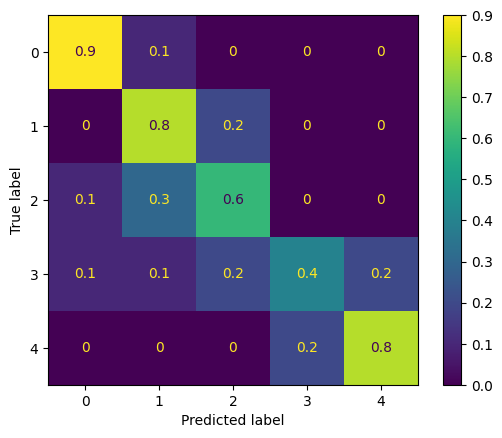

In [89]:
unoptimized_labels, unoptimized_predictions, unoptimized_kappa, unoptimized_mae, unoptimized_cm, unoptimized_cr = dspy_predict_and_evaluate(FewShotLearning())
print(f"Cohen's Kappa: {unoptimized_kappa:.04f}, MAE: {unoptimized_mae}")
print(unoptimized_cr)

Cohen's Kappa: 0.8720, MAE: 0.38

precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.75      0.60      0.67        10
           2       0.55      0.60      0.57        10
           3       0.57      0.40      0.47        10
           4       0.75      0.90      0.82        10

    accuracy                           0.68        50
   macro avg       0.67      0.68      0.67        50
weighted avg       0.67      0.68      0.67        50

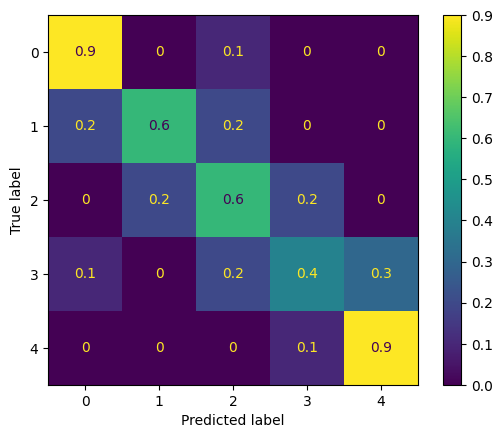

In [125]:
optimized_labels, optimized_predictions, optimized_kappa, optimized_mae, optimized_cm, optimized_cr = dspy_predict_and_evaluate(optimized_few_shot)
print(f"Cohen's Kappa: {optimized_kappa:.04f}, MAE: {optimized_mae}")
print(optimized_cr)